## Measurements Quality Assessments using data from the Solcast API
In this real-world example we are going to use Historic data from the Solcast API to perform quality assurance on some measurement data. The measurements data used in the exercise is a re-worked time-series sourced from the Goodwin Creek Mississippi SURFRAD site. For an example on how to source measurement data from SURFRAD, check the `Comparing Solcast API data with meas measurements.ipynb` example. 

We will be using some external libraries for this task, in particular [Pvanalytics](https://pvanalytics.readthedocs.io/en/stable/), an industry standard when it comes to PV analytics, and [Plotly](https://plotly.com/python/), a common Python plotting library.

In [1]:
# ! pip install plotly pvanalytics

In [2]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

from pvanalytics import quality

Let"s load a set of measurements, and retrieve the time-series for this location from the Solcast API with `solcast.historic.radiation_and_weather`

In [3]:
measurements = pd.read_csv("measurements.csv", index_col=0, parse_dates=True)
measurements.head()

,ghi
period_end[UTC-5],
2023-01-14 00:00:00,-0.80
2023-01-14 00:05:00,-0.80
2023-01-14 00:10:00,-0.80
2023-01-14 00:15:00,-0.80
2023-01-14 00:20:00,-0.82


In [4]:
# retrieve relevant Solcast data
from solcast import historic

# NOTE: this will consume an API request!
resp = historic.radiation_and_weather(
    latitude=34.2547,
    longitude=-89.8729,
    output_parameters=["ghi", "clearsky_ghi", "zenith"],
    start=measurements.index.min() - pd.Timedelta(hours=12),
    end=measurements.index.max() + pd.Timedelta(hours=12),
    period="PT5M",
)
solcast = resp.to_pandas()
# convert to tz-naive since we will be comparing to measurements
solcast.index = solcast.index.tz_convert(None)  

solcast.head()

,ghi,clearsky_ghi,zenith
period_end,,,
2023-01-13 12:05:00,0,0,103
2023-01-13 12:10:00,0,0,102
2023-01-13 12:15:00,0,0,101
2023-01-13 12:20:00,0,0,100
2023-01-13 12:25:00,0,0,99


## Time zone check
Here we shift the solcast timeseries in UTC to match the local time of the measurements.

We validate the shift by looking at a cloud-free day (2023-01-15) and check that the peaks align

In [5]:
def detect_timezone_shift(ghi_to_be_shifted: pd.Series, target_ghi: pd.Series) -> float:
    """Computes the necessary timezone shift to best match the supplied ghi timeseries.
    
    Here we shift the timeseries by 15min each time,
    and pick the shift that gives the lowest error.
    This works quite well because of the day/night signature
    in the timeseries, so even a moderate amount of corrupt
    data will generally not break this check.

    However, there are certaintly pathological corrupt measurements
    that would cause this timezone shift detection to fail - use with caution!
    
    """
    src = ghi_to_be_shifted.copy()
    errors = {}
    for shift in np.arange(-13, 13.25, 0.25):
        shifted = src.copy()
        shifted.index = shifted.index + pd.Timedelta(hours=shift)
        errors[shift] = (shifted - target_ghi).abs().mean()
    errors = pd.Series(errors)
    return errors.idxmin()


tz = detect_timezone_shift(solcast["ghi"], measurements["ghi"])
print(f"Detected timezone shift: {tz} hours")

# create a combined Solcast + Measurements DataFrame
df = solcast.copy()
df.index = df.index + pd.Timedelta(hours=tz)
df = df.join(measurements, lsuffix="_solcast", rsuffix="_meas", how="left")
df = df.loc[slice(measurements.index.min(), measurements.index.max())].copy()

display(df.head())

Detected timezone shift: -5.0 hours


,ghi_solcast,clearsky_ghi,zenith,ghi_meas
period_end,,,,
2023-01-14 00:00:00,0,0,160,-0.80
2023-01-14 00:05:00,0,0,161,-0.80
2023-01-14 00:10:00,0,0,162,-0.80
2023-01-14 00:15:00,0,0,162,-0.80
2023-01-14 00:20:00,0,0,163,-0.82


Now to plot up the timeshift change

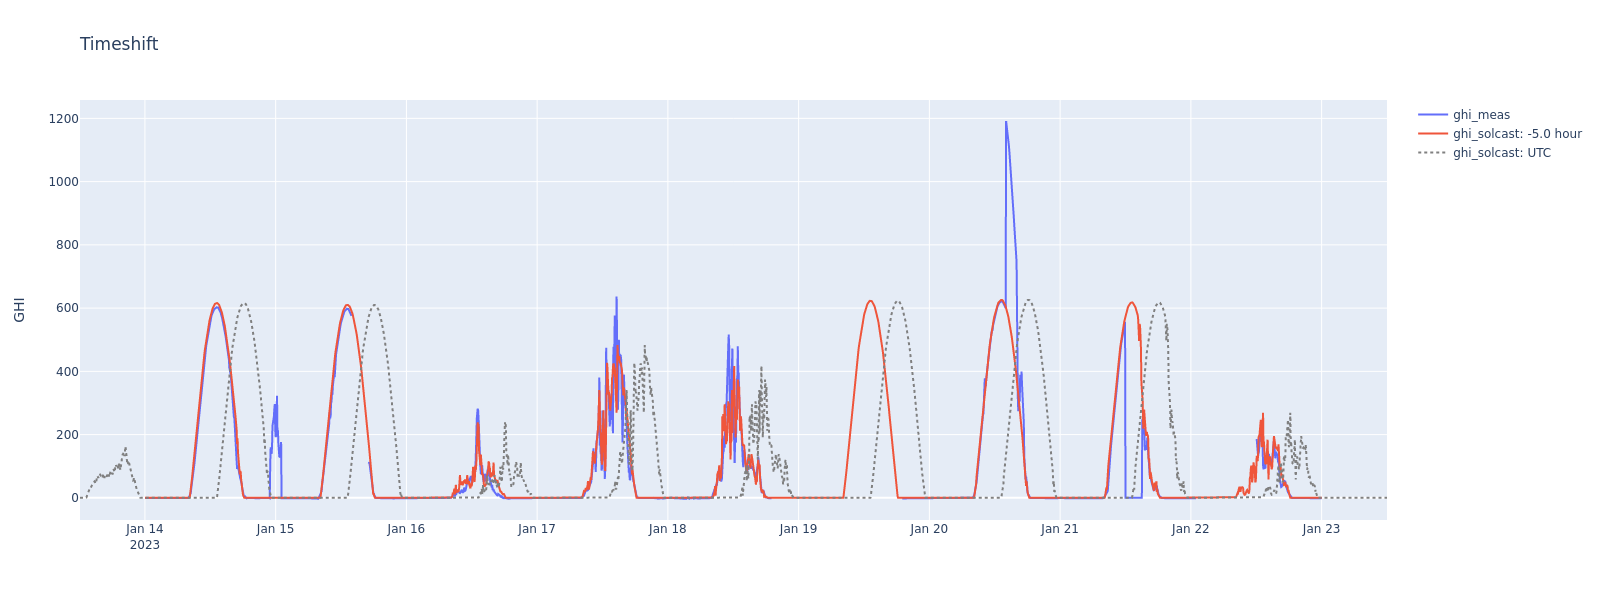

In [6]:
fig = go.Figure()
# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas"),
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_solcast"], name=f"ghi_solcast: {tz} hour"),
)
fig.add_trace(
    go.Scatter(x=solcast.index, y=solcast["ghi"], name="ghi_solcast: UTC", marker=dict(color="grey"), line=dict(dash="dot")),
)

fig.update_layout(autosize=False, width=1600, height=600, title="Timeshift")
fig.update_yaxes(title_text="GHI")
fig.show()

## Missing and Stale data
A common issue with measurement data is to have an incomplete time series with missing or stale data. We can identify gaps and stale sequences in our data using pvanalytics" [quality.gaps.complete](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.complete.html) and [quality.gaps.stale_values_diff](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.stale_values_diff.html). Once identified we can fill or replace their values with Solcast API"s Historial actuals.

In [7]:
missing = df["ghi_meas"].isnull()
# only check sun-up periods for staleness (expecting zeros at nighttime!)
stale = quality.gaps.stale_values_diff(df["ghi_meas"].where(df["zenith"] < 88), mark="all")
df["incomplete_or_stale"] =  missing | stale

# make a quality-controlled GHI
df["ghi_QC"] = df["ghi_meas"].mask(df["incomplete_or_stale"], df["ghi_solcast"])

Let"s plot the results. The dashed line represents where we filled missing measurement data with Solcast"s Historical data.

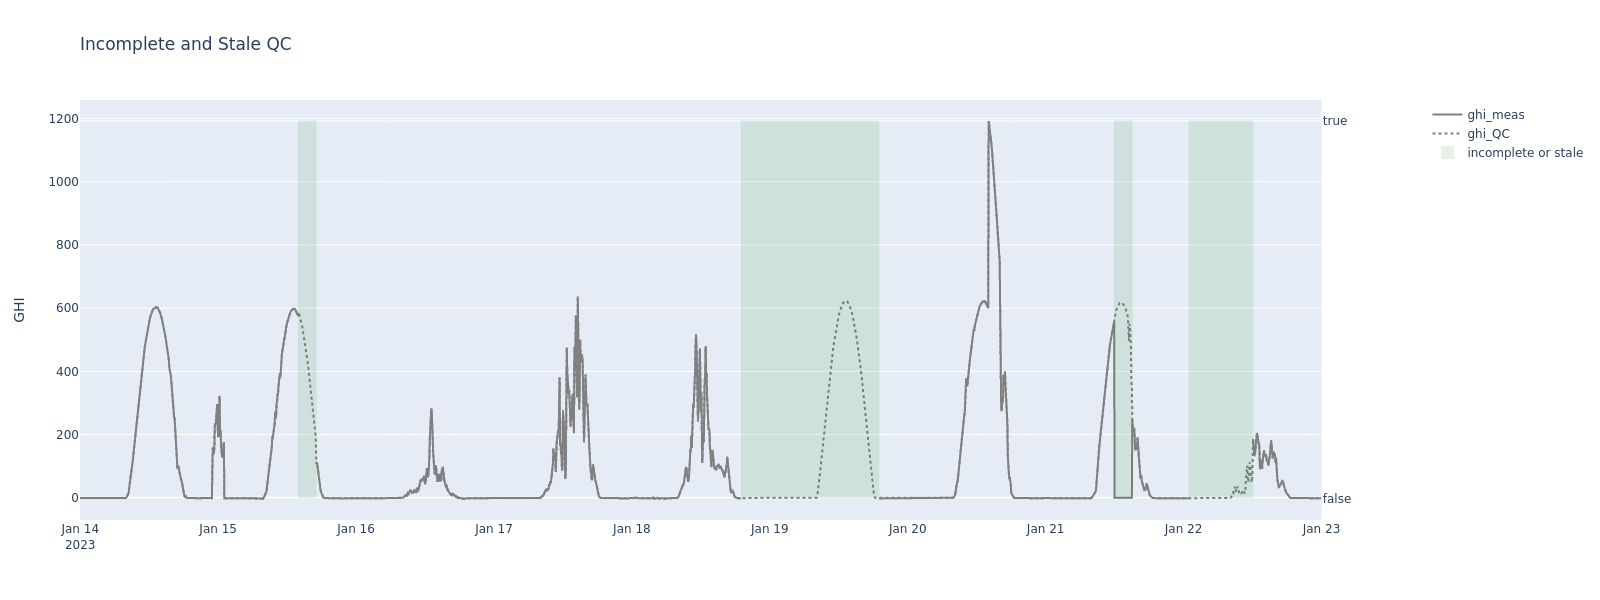

In [8]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_QC"], name="ghi_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["incomplete_or_stale"], 
        name="incomplete or stale", 
        marker_line_width=1, 
        marker_color="green",
        marker_line_color="green",
        opacity=0.1
    ),
    secondary_y=True,
)

fig.update_layout(autosize=False, width=1600, height=600, title="Incomplete and Stale QC")
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

### Non-Physical Values
A common way to flag anomalous values is to check for values that exceed the clearsky values. We will use the [clearsky_limits](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.irradiance.clearsky_limits.html#pvanalytics.quality.irradiance.clearsky_limits) function from `pvanalytics` with clearsky values from the Solcast API.

In [9]:
# check we do not exceed clearsky irradiance during the day 
df["non_physical"] = ~quality.irradiance.clearsky_limits(
    df["ghi_QC"], df["clearsky_ghi"], csi_max=1.2
) & (df["zenith"] < 88)

# cloud enhancement can temporarily exceed clearsky limits (especially on a 5min scale)
# so check that there is at least two contiguous timesteps
df["non_physical"] = ( 
    (df["non_physical"] & df["non_physical"].shift(1))
    | (df["non_physical"] & df["non_physical"].shift(-1))
)

# night time
df["non_physical"] = df["non_physical"] | (
    (df["ghi_meas"] > 0) & (df["clearsky_ghi"] == 0) & (df["zenith"] > 95)
)

# replace non physical data with Solcast GHI
df["ghi_QC"] = df["ghi_QC"].mask(df["non_physical"], other=df["ghi_solcast"])

Let's plot the results to see where we have flagged values 

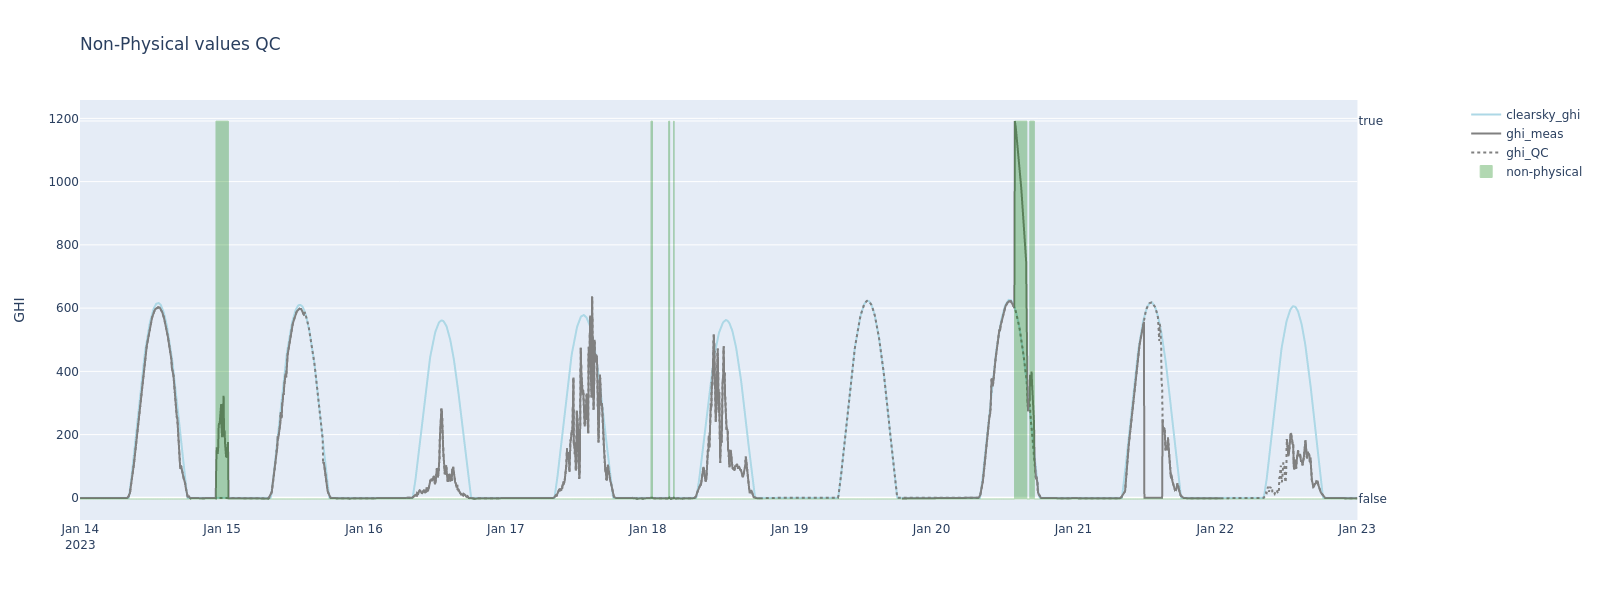

In [10]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["clearsky_ghi"], name="clearsky_ghi", marker=dict(color="lightblue")),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_QC"], name="ghi_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["non_physical"], 
        name="non-physical", 
        marker_line_width=1, 
        opacity=0.3, 
        marker_color="green",
        marker_line_color="green"
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Non-Physical values QC",
    autosize=False,
    width=1600,
    height=600,
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()